<a href="https://colab.research.google.com/github/xcellentbird/STUDY/blob/main/%20AI/KDT%20AI/%EC%8B%A0%EA%B2%BD%EB%A7%9D%20%EA%B8%B0%EC%B4%88/mnist_mlp_pytorch_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Layer Perceptron, MNIST
---
In this notebook, we will train an MLP to classify images from the [MNIST database](http://yann.lecun.com/exdb/mnist/) hand-written digit database.

The process will be broken down into the following steps:
>1. Load and visualize the data
2. Define a neural network
3. Train the model
4. Evaluate the performance of our trained model on a test dataset!

Before we begin, we have to import the necessary libraries for working with data and PyTorch.

In [18]:
# import libraries
import torch
import numpy as np

---
## Load and Visualize the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

Downloading may take a few moments, and you should see your progress as the data is loading. You may also choose to change the `batch_size` if you want to load more data at a time.

This cell will create DataLoaders for each of our datasets.

In [19]:
from torchvision import datasets
import torchvision.transforms as transforms

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# convert data to torch.FloatTensor
train_transform = transforms.Compose([transforms.RandomRotation(degrees=(-20, 20)), transforms.ToTensor()])
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=train_transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

### Visualize a Batch of Training Data

The first step in a classification task is to take a look at the data, make sure it is loaded in correctly, then make any initial observations about patterns in that data.

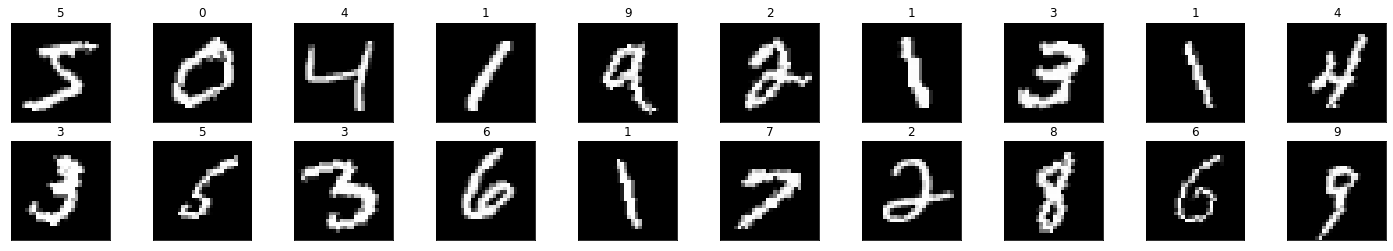

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

### View an Image in More Detail

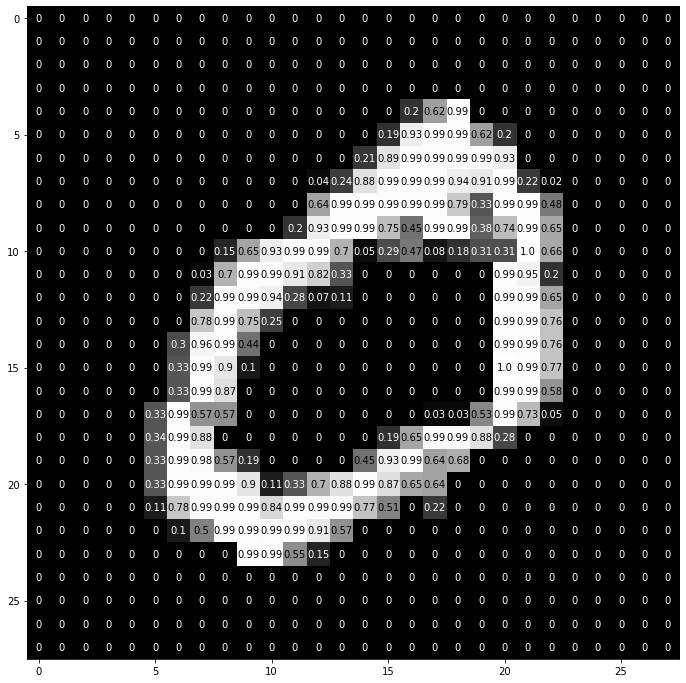

In [21]:
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

---
## Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)

The architecture will be responsible for seeing as input a 784-dim Tensor of pixel values for each image, and producing a Tensor of length 10 (our number of classes) that indicates the class scores for an input image. This particular example uses two hidden layers and dropout to avoid overfitting.

In [22]:
import torch.nn as nn
import torch.nn.functional as F

## Define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5) # 10 * 24 * 24
        self.bn1 = nn.BatchNorm2d(10)
        self.pool1 = nn.MaxPool2d(2) # 10 * 12 * 12

        self.conv2 = nn.Conv2d(10, 100, kernel_size=5) # 100 * 8 * 8
        self.bn2 = nn.BatchNorm2d(100)
        self.pool2 = nn.MaxPool2d(2) # 100 * 4 * 4

        self.conv3 = nn.Conv2d(100, 64, kernel_size=3) # 10 * 2 * 2
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(2) # 64 * 1 * 1

        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool1(F.dropout(F.silu(self.bn1(self.conv1(x)))))
        x = self.pool2(F.dropout(F.silu(self.bn2(self.conv2(x)))))
        x = self.pool3(F.dropout(F.silu(self.bn3(self.conv3(x)))))

        # flatten image input
        x = x.view(x.size(0), -1)
        x = F.dropout(F.silu(self.fc1(x)))
        x = self.fc2(x)
        x = F.softmax(x)
        
        return x

# initialize the NN
model = Net()
print(model)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 100, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(100, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)


###  Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

It's recommended that you use cross-entropy loss for classification. If you look at the documentation (linked above), you can see that PyTorch's cross entropy function applies a softmax funtion to the output layer *and* then calculates the log loss.

In [23]:
## Specify loss and optimization functions

# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)

---
## Train the Network

The steps for training/learning from a batch of data are described in the comments below:
1. Clear the gradients of all optimized variables
2. Forward pass: compute predicted outputs by passing inputs to the model
3. Calculate the loss
4. Backward pass: compute gradient of the loss with respect to model parameters
5. Perform a single optimization step (parameter update)
6. Update average training loss


In [24]:
model = model.cuda()
criterion = criterion.cuda()

In [25]:
# number of epochs to train the model
n_epochs = 50  # suggest training between 10-50 epochs

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train() # prep model for training

    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        data = data.cuda()
        target = target.cuda()
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    # print training statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)

    # initialize lists to monitor test loss and accuracy
    test_loss = 0.0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    #########################
    # test(valid) the model #
    #########################
    
    model.eval() # prep model for *evaluation*

    for data, target in test_loader:
        data = data.cuda()
        target = target.cuda()
        
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update test loss 
        test_loss += loss.item()*data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        # calculate test accuracy for each object class
        for i in range(batch_size):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    # calculate and print avg test loss
    test_loss = test_loss/len(test_loader.dataset)

    print('Epoch: {} \tTraining Loss: {:.6f} \tTest Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        test_loss
        ))

    print('Test Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)), '\n')
    
    #scheduler.step()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1 	Training Loss: 1.714289 	Test Loss: 1.542178
Test Accuracy (Overall): 92% (9279/10000) 

Epoch: 2 	Training Loss: 1.567843 	Test Loss: 1.521133
Test Accuracy (Overall): 94% (9442/10000) 

Epoch: 3 	Training Loss: 1.549687 	Test Loss: 1.514291
Test Accuracy (Overall): 95% (9509/10000) 

Epoch: 4 	Training Loss: 1.540419 	Test Loss: 1.511889
Test Accuracy (Overall): 95% (9530/10000) 

Epoch: 5 	Training Loss: 1.535174 	Test Loss: 1.505088
Test Accuracy (Overall): 95% (9596/10000) 

Epoch: 6 	Training Loss: 1.531880 	Test Loss: 1.501603
Test Accuracy (Overall): 96% (9623/10000) 

Epoch: 7 	Training Loss: 1.527450 	Test Loss: 1.501001
Test Accuracy (Overall): 96% (9623/10000) 

Epoch: 8 	Training Loss: 1.525114 	Test Loss: 1.500420
Test Accuracy (Overall): 96% (9640/10000) 

Epoch: 9 	Training Loss: 1.521260 	Test Loss: 1.493417
Test Accuracy (Overall): 96% (9699/10000) 

Epoch: 10 	Training Loss: 1.518390 	Test Loss: 1.493781
Test Accuracy (Overall): 96% (9692/10000) 

Epoch: 11

---
## Test the Trained Network

Finally, we test our best model on previously unseen **test data** and evaluate it's performance. Testing on unseen data is a good way to check that our model generalizes well. It may also be useful to be granular in this analysis and take a look at how this model performs on each class as well as looking at its overall loss and accuracy.

#### `model.eval()`

`model.eval(`) will set all the layers in your model to evaluation mode. This affects layers like dropout layers that turn "off" nodes during training with some probability, but should allow every node to be "on" for evaluation!

In [26]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for *evaluation*

for data, target in test_loader:
    data = data.cuda()
    target = target.cuda()
    
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Test Loss: 1.480462

Test Accuracy of     0: 98% (969/980)
Test Accuracy of     1: 99% (1127/1135)
Test Accuracy of     2: 98% (1018/1032)
Test Accuracy of     3: 98% (993/1010)
Test Accuracy of     4: 98% (969/982)
Test Accuracy of     5: 97% (874/892)
Test Accuracy of     6: 98% (945/958)
Test Accuracy of     7: 98% (1016/1028)
Test Accuracy of     8: 97% (945/974)
Test Accuracy of     9: 97% (980/1009)

Test Accuracy (Overall): 98% (9836/10000)


### Visualize Sample Test Results

This cell displays test images and their labels in this format: `predicted (ground-truth)`. The text will be green for accurately classified examples and red for incorrect predictions.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


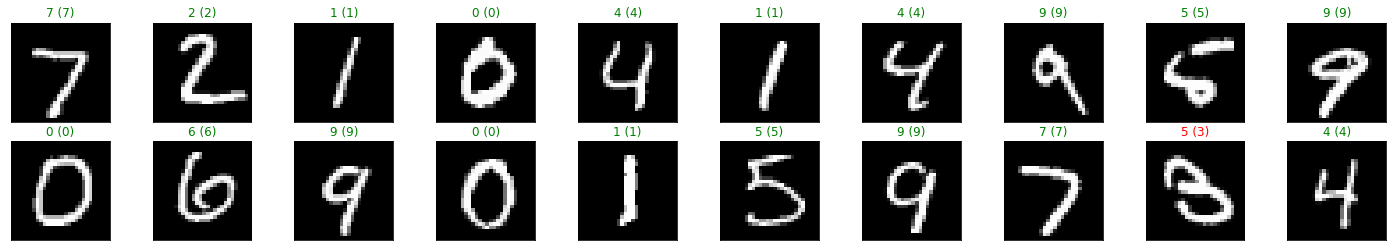

In [27]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.cpu().numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))